## Dependencies

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks, welch
from scipy.stats import skew, kurtosis, iqr
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyRegressor
from vmdpy import VMD
import joblib


## Database structure exploration

In [2]:

folder_path = 'PPG-BP Database/Data File/0_subject'
file_count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])

print(f'There are {file_count} files in the folder.')

There are 657 files in the folder.


In [3]:
file_path = 'PPG-BP Database/Data File/0_subject/2_2.txt'

with open(file_path, 'r') as file:
    data = file.readlines()

# Convert the data to a list of sec2
sec2 = [float(num) for line in data for num in line.strip().split('\t')]

# Show the length of the series
print(f'The length of the series is {len(sec2)}')

The length of the series is 2100


In [4]:
file_path = 'PPG-BP Database/Data File/0_subject/2_3.txt'

with open(file_path, 'r') as file:
    data = file.readlines()

# Convert the data to a list of sec3
sec3 = [float(num) for line in data for num in line.strip().split('\t')]

# Show the length of the series
print(f'The length of the series is {len(sec3)}')

The length of the series is 2100


## Filter, Clean, Normalize PPG
 To mitigate signal distortion in the PPG data, a Butterworth filter technique for
 waveform smoothing, using the zero-phase filter FiltFilt, was employed. This filtering
 technique ensures the preservation of the signal trend behavior by facilitating low-pass and
 high-pass frequency cutoffs. Specifically, a third-order Butterworth filter was employed,
 with low-pass and high-pass cutoffs set at 0.5 Hz and 15 Hz, respectively

In [5]:
fs = 1000.0  # Sampling frequency
lowcut = 0.5
highcut = 15.0

def remove_motion_artifacts(ppg_signal, alpha=2000, tau=0, K=5, DC=0, init=1, tol=1e-7):
    """
    Remove motion artifacts from the PPG signal using Variational Mode Decomposition (VMD).

    Parameters:
    ppg_signal (numpy array): The input PPG signal.
    alpha (float): Bandwidth constraint parameter.
    tau (float): Time-step of the dual ascent (0 for noise-slack).
    K (int): The number of modes to be recovered.
    DC (int): DC part (0: no DC part, 1: DC part).
    init (int): Initialization method (0: random, 1: uniform).
    tol (float): Tolerance for convergence criterion.

    Returns:
    numpy array: The cleaned PPG signal.
    """
    
    # Perform VMD
    u, u_hat, omega = VMD(ppg_signal, alpha, tau, K, DC, init, tol)

    cleaned_signal = np.sum(u[:4], axis=0) # Sum the first 4 modes.

    return cleaned_signal

def butter_bandpass(lowcut, highcut, fs, order=6):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=6):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y



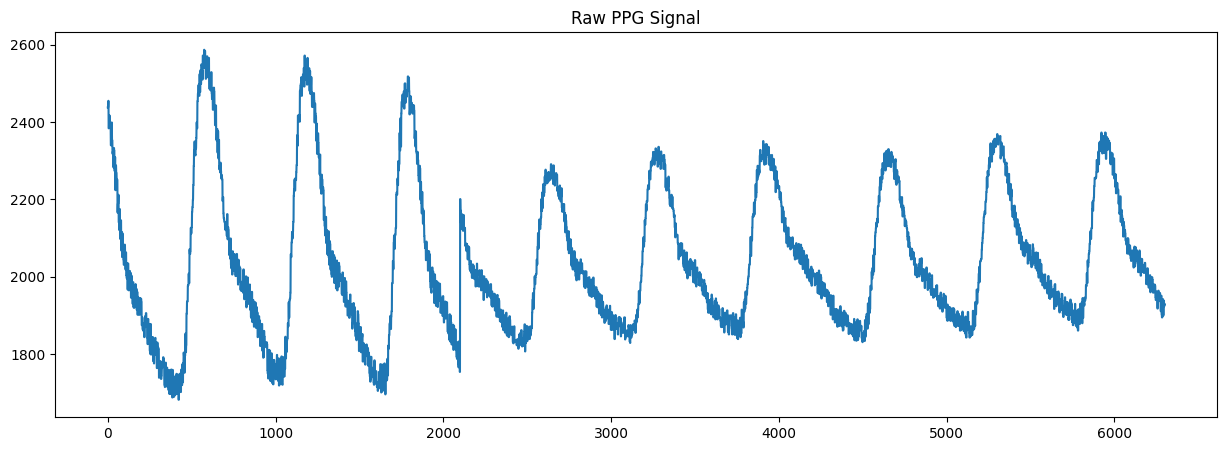

In [8]:
raw_ppg = []  # Create an empty list to store the raw PPG data

for i in range(1,4):
    file_path = f'PPG-BP Database/Data File/0_subject/2_{i}.txt'
    with open(file_path, 'r') as file:
        data = file.readlines()
        raw_ppg.extend([float(num) for line in data for num in line.strip().split('\t')])

plt.figure(figsize=(15, 5))
plt.title('Raw PPG Signal')
plt.plot(raw_ppg)


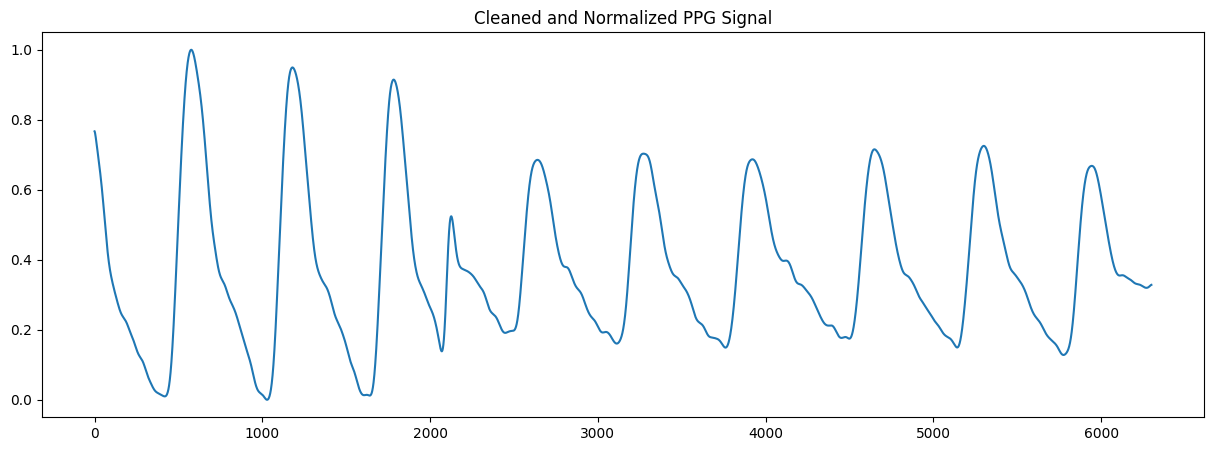

In [10]:

filtered_ppg = butter_bandpass_filter(raw_ppg, lowcut, highcut, fs, order=3)

cleaned_ppg = remove_motion_artifacts(filtered_ppg)
normalized_ppg = (cleaned_ppg - np.min(cleaned_ppg)) / (np.max(cleaned_ppg) - np.min(cleaned_ppg))
# cleaned_ppg = remove_motion_artifacts(sec1)
#plot wider image
plt.figure(figsize=(15, 5))
plt.title('Cleaned and Normalized PPG Signal')
plt.plot(normalized_ppg)

## Extracting features


In [11]:
def extract_features(ppg_segment, fs=1000):
    # Initialize the dictionary to hold features
    features = {}
    features = {}
    
    # Detect peaks for ppg
    peaks, _ = find_peaks(ppg_segment, distance=fs/2.5, prominence=0.1)  # Adjust distance based on expected heart rate range
    # Detect foot points
    foot_points, _ = find_peaks(-ppg_segment, distance=fs/2.5, prominence=0.1)
    # Ensure there's a foot point before the first peak
    if foot_points[0] > peaks[0]:
        peaks = peaks[1:]
    # Ensure there's a foot point after the last peak
    if foot_points[-1] < peaks[-1]:
        peaks = peaks[:-1]


    try:
        x = []
        t1 = []
        i=0
        while i < len(peaks):
            if peaks[i] > foot_points[i]:
                x.append(ppg_segment[peaks[i]] - ppg_segment[foot_points[i]])
                t1.append((peaks[i] - foot_points[i]) / fs)
                i += 1  # Move to the next element
            else:
                # Remove the invalid peak
                peaks = np.delete(peaks, i)
                # No need to increment i, as we want to check the next element at the same index

        # Calculate signal derivatives and ensure they start from 0.
        del1 = np.gradient(ppg_segment)
        del1 = del1 - del1[0]
        del2 = np.gradient(del1)
        del2 = del2 - del2[0]

        # Detect peaks for del1
        del1_peaks, _ = find_peaks(del1, distance=fs/2.5)  # Adjust distance based on expected heart rate range
        del1_foot_points, _ = find_peaks(-del1, distance=fs/2.5)

        # Ensure there's a foot point before the first peak for del1
        if del1_foot_points[0] > del1_peaks[0]:
            del1_peaks = del1_peaks[1:]

        # Detect peaks for del2
        del2_peaks, _ = find_peaks(del2, distance=fs/2.5)  # Adjust distance based on expected heart rate range
        del2_foot_points, _ = find_peaks(-del2, distance=fs/2.5)

        # Ensure there's a foot point before the first peak for del2
        if del2_foot_points[0] > del2_peaks[0]:
            del2_peaks = del2_peaks[1:]

        # Ensure that both foot points of del1 and del2 have the same length
        common_len = np.min([len(del1_foot_points), len(del2_foot_points), len(del1_peaks), len(del2_peaks)]) 
        del1_foot_points = del1_foot_points[:common_len]
        del2_foot_points = del2_foot_points[:common_len]
        del1_peaks = del1_peaks[:common_len]
        del2_peaks = del2_peaks[:common_len]

        ta2, tv2, tv1, v1, v2 = [], [], [], [], []
        for i in range(common_len-1):
            ta2.append((del2_foot_points[i+1] - del2_foot_points[i])/fs)
            tv2.append((del1_foot_points[i+1] - del1_foot_points[i])/fs)
            v2.append(del1[del1_foot_points[i]])

        i=0
        while i < len(del1_peaks):
            if del1_foot_points[i] < del1_peaks[i]:
                tv1.append((del1_peaks[i] - del1_foot_points[i])/fs)
                v1.append(del1[del1_peaks[i]] - del1[del1_foot_points[i]])
                i+=1
            else:
                del1_peaks = np.delete(del1_peaks, i)

        tpi = np.diff(foot_points) / fs  # Convert indices to time intervals

        tpp = np.diff(peaks) / fs  # Convert indices to time intervals

        maxfreq = np.argmax(np.fft.fft(ppg_segment).real)



        # Find widths at 25% amplitude...TODO: w_50 ---> straight line from prev foot to peak 50%
        def find_w_25(signal, x, foot_points, peaks):
            widths_25 = []
            for i in range(len(peaks)):
                amp_25 = (0.25 * x[i]) + signal[foot_points[i]]
                left_idx= np.where(signal[foot_points[i]:peaks[i]] <= amp_25)[0][-1] + foot_points[i]
                try:
                    right_idx = np.where(signal[peaks[i]:foot_points[i+1] if i+1 < len(foot_points) else len(signal)] <= amp_25)[0][0] + peaks[i]
                except IndexError:
                    right_idx = foot_points[i+1] - foot_points[i]
                width_25 = (right_idx - left_idx) / fs
                widths_25.append(width_25)
            return widths_25
        w_25 = find_w_25(ppg_segment, x, foot_points, peaks)

        freqs, psd = welch(ppg_segment, fs)
        features['dominant_freq'] = freqs[np.argmax(psd)]
        
        min_length = min(len(v1), len(v2))
        v1 = v1[:min_length]
        v2 = v2[:min_length]
        features['mean_v2/v1'] = np.mean(np.array(v2) / np.array(v1))
        features['std_v2/v1'] = np.std(np.array(v2) / np.array(v1))
        features['kurtosis_sig'] = kurtosis(ppg_segment)
        # print(f'tpi = {len(tpi)}, t1 = {len(t1)}, x = {len(x)}')
        min_length = min(len(tpi), len(t1), len(x))
        tpi = tpi[:min_length]
        t1 = t1[:min_length]
        x = x[:min_length]

        features['mean_x/(tpi-t1)'] = np.mean(np.array(x) / (np.array(tpi) - np.array(t1)))
        features['mean_tv2/ta2'] = np.mean(np.array(tv2) / np.array(ta2))

        # Important SpO2 features
        features['mean_t1/tpi'] = np.mean(np.array(t1) / np.array(tpi))
        features['mean_ta2'] = np.mean(ta2) 
        features['mean_t1'] = np.mean(t1)
        features['mean_w_25'] = np.mean(w_25)
        features['mean_tv2'] = np.mean(tv2) 
        features['std_tpp'] = np.std(tpp)
        features['skewness_sig'] = skew(ppg_segment)
        features['mean_tpi'] = np.mean(tpi)
        features['mean_tpp'] = np.mean(tpp)
        features['mean_tv1'] = np.mean(tv1)
    except Exception as e:
        print(e)
        # Plot the PPG signal with detected peaks and foot points
        plt.figure(figsize=(15, 3))
        plt.plot(ppg_segment, label='PPG Signal')
        plt.plot(foot_points, ppg_segment[foot_points], 'go', label='Foot Points')
        plt.plot(peaks, ppg_segment[peaks], 'ro', label='Peaks')
        plt.legend()
        plt.xlabel('Sample Index')
        plt.ylabel('Amplitude')
        plt.title('PPG Signal with Detected Peaks and Foot Points')
        plt.show()
        raise KeyboardInterrupt

    return features


Extracted features of a random ppg signal

In [12]:
extract_features(cleaned_ppg, fs)

{'dominant_freq': 3.90625,
 'mean_v2/v1': -0.2797638520011672,
 'std_v2/v1': 0.19773389957628906,
 'kurtosis_sig': -0.11344383437294958,
 'mean_x/(tpi-t1)': 1341.5902386646167,
 'mean_tv2/ta2': 1.0155505767931765,
 'mean_t1/tpi': 0.2971395297411603,
 'mean_ta2': 0.5894,
 'mean_t1': 0.20222222222222222,
 'mean_w_25': -0.2602222222222222,
 'mean_tv2': 0.5960000000000001,
 'std_tpp': 0.07900949310051293,
 'skewness_sig': 0.6932787849063052,
 'mean_tpi': 0.6502222222222223,
 'mean_tpp': 0.6709999999999999,
 'mean_tv1': 0.40445454545454546}

### Feature Extraction for all the signals of Dataset

In [13]:

# Load the Excel file, skipping the first row
excel_path = 'PPG-BP Database/Data File/PPG-BP dataset.xlsx'
df_excel = pd.read_excel(excel_path, skiprows=1)

# Initialize lists to hold features and labels
all_features = []
labels = []

# Iterate through each subject ID in the Excel file
print('Processing Subject ID:', end=' ')
for index, row in df_excel.iterrows():
    print(f'{row["subject_ID"]}', end=' ')
    subject_id = row['subject_ID']
    systolic_bp = row['Systolic Blood Pressure(mmHg)']
    diastolic_bp = row['Diastolic Blood Pressure(mmHg)']
    hr = row['Heart Rate(b/m)']
    
    # Concatenate signals from text files
    signals = []
    for i in range(1, 4):
        file_path = f'PPG-BP Database/Data File/0_subject/{subject_id}_{i}.txt'
        with open(file_path, 'r') as file:
            data = file.readlines()
        signals.extend([float(num) for line in data for num in line.strip().split('\t')])
    if len(signals) != 2100*3:
        print(f'!! Length of concatenated signals: {len(signals)}')
        
    
    # Clean the concatenated signals
    filtered_ppg = butter_bandpass_filter(signals, lowcut, highcut, fs, 2)
    cleaned_ppg = remove_motion_artifacts(filtered_ppg)
    normalized_ppg = (cleaned_ppg - np.min(cleaned_ppg)) / (np.max(cleaned_ppg) - np.min(cleaned_ppg))

    # Extract features from the cleaned signals
    features = extract_features(normalized_ppg, fs)
    all_features.append(features)
    
    # Append the labels
    labels.append({'Systolic_BP': systolic_bp, 'Diastolic_BP': diastolic_bp, 'Heart_Rate': hr})

# Convert the features and labels to DataFrames
features_df = pd.DataFrame(all_features)
labels_df = pd.DataFrame(labels)

# Save the features and labels to CSV files
features_df.to_csv('features.csv', index=False)
labels_df.to_csv('labels.csv', index=False)


Processing Subject ID: 2 3 6 8 9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 25 26 27 29 30 31 32 34 35 38 40 41 43 45 47 48 50 51 52 53 54 55 56 57 58 60 61 62 63 64 65 66 67 83 84 85 86 87 88 89 90 91 92 93 95 96 97 98 99 100 103 104 105 106 107 108 110 111 112 113 114 115 116 119 120 122 123 124 125 126 127 128 130 131 134 135 136 137 138 139 140 141 142 144 145 146 148 149 150 151 152 153 154 155 156 157 158 160 161 162 163 164 165 166 167 169 170 171 172 173 174 175 176 178 179 180 182 183 184 185 186 188 189 190 191 192 193 195 196 197 198 199 200 201 203 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 226 227 228 229 230 231 !! Length of concatenated signals: 10500
232 233 234 235 237 239 240 241 242 243 244 245 246 247 248 250 251 252 253 254 256 257 259 403 404 405 406 407 409 410 411 412 413 414 415 416 417 418 419 

### Extracted features and labels dataframes

In [14]:
features_df.head()

,dominant_freq,mean_v2/v1,std_v2/v1,kurtosis_sig,mean_x/(tpi-t1),mean_tv2/ta2,mean_t1/tpi,mean_ta2,mean_t1,mean_w_25,mean_tv2,std_tpp,skewness_sig,mean_tpi,mean_tpp,mean_tv1
0,3.90625,-0.270378,0.084441,-0.131604,-1.038195,1.019405,0.910061,0.584000,0.549125,-1.883250,0.589667,0.083841,0.584725,0.591375,0.673857,0.843000
1,3.90625,-0.319892,0.167501,-1.261955,2.225402,0.997846,0.392322,0.589875,0.274875,0.385000,0.575375,0.123428,0.435576,0.698500,0.701857,0.657778
2,3.90625,-0.373737,0.355414,-0.669497,-2.097533,1.068843,1.077508,0.531400,0.698429,-2.098143,0.547800,0.149742,0.371467,0.675571,0.802667,0.568727
3,3.90625,-0.297116,0.057321,-1.000757,-2.428270,1.114598,0.884190,0.628125,0.563875,-1.942500,0.682875,0.111119,0.527520,0.630125,0.718286,0.464125
4,3.90625,-0.391055,0.111892,-1.332055,1.910249,1.262507,0.335218,0.477889,0.222000,0.402250,0.576889,0.099704,0.255129,0.654750,0.662143,0.793500


In [15]:
labels_df.head()

,Systolic_BP,Diastolic_BP,Heart_Rate
0,161,89,97
1,160,93,76
2,101,71,79
3,136,93,87
4,123,73,73


In [ ]:
# import pandas as pd

# # Load the features and labels from CSV files
# features_df = pd.read_csv('final_features.csv')
# labels_df = pd.read_csv('final_labels.csv')

# # Display the first few rows of the DataFrames to verify
# print(features_df.head())
# print(labels_df.head())

## Correlations with the targets

### SBP correlation

In [16]:

# Calculate the correlation between the features and labels
corr_matrix = features_df.corrwith(labels_df['Systolic_BP']).abs().sort_values(ascending=False)
print(f'SBP correlation:\n{corr_matrix}')


SBP correlation:
mean_t1            0.200827
mean_t1/tpi        0.185601
std_tpp            0.077729
mean_w_25          0.069583
kurtosis_sig       0.060117
std_v2/v1          0.037617
skewness_sig       0.031400
mean_ta2           0.022403
mean_tv1           0.021999
mean_tpi           0.019788
mean_tv2           0.018964
mean_tv2/ta2       0.015484
mean_x/(tpi-t1)    0.005084
mean_v2/v1         0.002752
mean_tpp           0.002391
dominant_freq           NaN
dtype: float64


### DBP correlation

In [17]:

corr_matrix = features_df.corrwith(labels_df['Diastolic_BP']).abs().sort_values(ascending=False)
print(f'\n\nDBP correlation:\n{corr_matrix}')



DBP correlation:
mean_t1/tpi        0.165564
skewness_sig       0.140098
mean_t1            0.138599
mean_tpi           0.105778
mean_tpp           0.081364
std_tpp            0.072016
mean_w_25          0.066670
mean_ta2           0.055986
mean_v2/v1         0.046800
mean_tv2           0.034802
std_v2/v1          0.025877
kurtosis_sig       0.021320
mean_x/(tpi-t1)    0.021026
mean_tv2/ta2       0.015273
mean_tv1           0.009278
dominant_freq           NaN
dtype: float64


## Train test split (80-20)

In [18]:

# Define the features and labels
X = features_df
y = labels_df

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the resulting datasets
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (175, 16)
X_test shape: (44, 16)
y_train shape: (175, 3)
y_test shape: (44, 3)


In [19]:
X_train.head()

,dominant_freq,mean_v2/v1,std_v2/v1,kurtosis_sig,mean_x/(tpi-t1),mean_tv2/ta2,mean_t1/tpi,mean_ta2,mean_t1,mean_w_25,mean_tv2,std_tpp,skewness_sig,mean_tpi,mean_tpp,mean_tv1
79,3.90625,-0.584119,0.821285,-1.101936,1.567970,0.972572,0.351882,0.509636,0.3105,0.509000,0.472909,0.043903,0.360714,0.864000,0.86040,0.569818
161,3.90625,-0.575923,0.574939,-0.692895,1.647232,1.023497,0.474104,0.523455,0.4724,0.584600,0.525273,0.241332,0.510085,0.981000,0.96925,0.279091
112,3.90625,-0.976888,0.912612,-0.506068,1.241063,1.096411,0.339676,0.486250,0.2950,0.442833,0.523083,0.110852,0.609053,0.849667,0.82640,0.225833
109,3.90625,-0.268702,0.345383,0.436691,0.972988,0.962558,0.165443,0.514818,0.1415,0.158167,0.476636,0.075735,0.883682,0.858500,0.84920,0.556000
101,3.90625,-0.658813,0.658410,-1.026791,1.621454,0.951882,0.423435,0.563182,0.3625,0.434500,0.525182,0.139591,0.538582,0.841500,0.83300,0.285583


In [20]:
y_train.head() 

,Systolic_BP,Diastolic_BP,Heart_Rate
79,133,73,66
161,159,86,62
112,163,63,64
109,115,71,70
101,137,84,62


In [21]:
y_train_sbp = y_train['Systolic_BP']
y_test_sbp = y_test['Systolic_BP']

y_train_dbp = y_train['Diastolic_BP']
y_test_dbp = y_test['Diastolic_BP']

y_train_hr = y_train['Heart_Rate']
y_test_hr = y_test['Heart_Rate']

## Model training

### SBP models

In [25]:
# Initialize the LazyRegressor
reg_sbp = LazyRegressor(predictions=True, custom_metric=mean_absolute_error, verbose=0, ignore_warnings=True, random_state=42)

# Fit the model
sbp_models, sbp_predictions = reg_sbp.fit(X_train, X_test, y_train_sbp, y_test_sbp)

# Display the results
sbp_models

100%|██████████| 42/42 [00:02<00:00, 14.26it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 898
[LightGBM] [Info] Number of data points in the train set: 175, number of used features: 15
[LightGBM] [Info] Start training from score 128.228571
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

,Adjusted R-Squared,R-Squared,RMSE,Time Taken,mean_absolute_error
Model,,,,,
LassoLarsIC,-0.58,0.01,18.50,0.01,14.29
LassoCV,-0.58,0.00,18.53,0.07,14.31
LassoLarsCV,-0.59,0.00,18.54,0.02,14.31
LarsCV,-0.59,0.00,18.54,0.02,14.31
NuSVR,-0.59,0.00,18.55,0.01,14.08
QuantileRegressor,-0.59,-0.00,18.58,0.91,14.36
OrthogonalMatchingPursuit,-0.59,-0.00,18.59,0.01,14.04
OrthogonalMatchingPursuitCV,-0.59,-0.00,18.59,0.01,14.04
ElasticNetCV,-0.59,-0.00,18.59,0.06,14.51


### DBP models

In [26]:

# Initialize the LazyRegressor
reg_dbp = LazyRegressor(predictions=True, custom_metric=mean_absolute_error, verbose=0, ignore_warnings=True, random_state=42)

# Fit the model
dbp_models, dbp_predictions = reg_dbp.fit(X_train, X_test, y_train_dbp, y_test_dbp)

# Display the results
dbp_models

100%|██████████| 42/42 [00:03<00:00, 13.86it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 898
[LightGBM] [Info] Number of data points in the train set: 175, number of used features: 15
[LightGBM] [Info] Start training from score 72.205714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

,Adjusted R-Squared,R-Squared,RMSE,Time Taken,mean_absolute_error
Model,,,,,
RandomForestRegressor,-0.48,0.07,9.15,0.44,7.33
BaggingRegressor,-0.50,0.06,9.21,0.06,7.01
XGBRegressor,-0.50,0.06,9.22,0.14,7.67
SVR,-0.55,0.03,9.37,0.01,7.25
GradientBoostingRegressor,-0.56,0.02,9.38,0.28,7.73
QuantileRegressor,-0.60,-0.00,9.51,0.91,7.48
ExtraTreesRegressor,-0.60,-0.01,9.52,0.20,7.51
GammaRegressor,-0.61,-0.01,9.56,0.01,7.67
TweedieRegressor,-0.62,-0.01,9.56,0.01,7.68


### HR models (optional)

In [27]:

# Initialize the LazyRegressor
reg_hr = LazyRegressor(predictions=True, custom_metric=mean_absolute_error, verbose=0, ignore_warnings=True, random_state=42)

# Fit the model
hr_models, hr_predictions = reg_hr.fit(X_train, X_test, y_train_hr, y_test_hr)

# Display the results
hr_models

  0%|          | 0/42 [00:00<?, ?it/s]

100%|██████████| 42/42 [00:02<00:00, 14.34it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 898
[LightGBM] [Info] Number of data points in the train set: 175, number of used features: 15
[LightGBM] [Info] Start training from score 74.245714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

,Adjusted R-Squared,R-Squared,RMSE,Time Taken,mean_absolute_error
Model,,,,,
ExtraTreesRegressor,0.38,0.61,5.53,0.19,4.27
AdaBoostRegressor,0.38,0.61,5.54,0.16,4.24
BayesianRidge,0.33,0.58,5.71,0.01,4.20
ElasticNet,0.33,0.58,5.73,0.01,4.23
KNeighborsRegressor,0.33,0.58,5.73,0.01,4.33
PoissonRegressor,0.33,0.58,5.75,0.01,4.27
GradientBoostingRegressor,0.32,0.57,5.77,0.25,4.54
GammaRegressor,0.32,0.57,5.78,0.01,4.31
SGDRegressor,0.31,0.57,5.81,0.01,4.31


### The BEST models for SBP and DBP

In [28]:
best_sbp_model = reg_sbp.provide_models(X_train, X_test, y_train_sbp, y_test_sbp)['NuSVR']
best_sbp_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['dominant_freq', 'mean_v2/v1', 'std_v2/v1', 'kurtosis_sig',
       'mean_x/(tpi-t1)', 'mean_tv2/ta2', 'mean_t1/tpi', 'mean_ta2', 'mean_t1',
       'mean_w_25', 'mean_tv2', 'std_tpp', 'skewness_sig', 'mean_tpi',
       'mean_tpp',...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoding',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index([], dtype='object')),
                                                 ('categorical_high',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoding',
                                                                   OrdinalEncoder())]),
                                                  Index([], dtype='object'))])),
                ('regressor', NuSVR())])

In [29]:
best_dbp_model = reg_dbp.provide_models(X_train, X_test, y_train_sbp, y_test_sbp)['LGBMRegressor']
best_dbp_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['dominant_freq', 'mean_v2/v1', 'std_v2/v1', 'kurtosis_sig',
       'mean_x/(tpi-t1)', 'mean_tv2/ta2', 'mean_t1/tpi', 'mean_ta2', 'mean_t1',
       'mean_w_25', 'mean_tv2', 'std_tpp', 'skewness_sig', 'mean_tpi',
       'mean_tpp',...
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoding',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index([], dtype='object')),
                                                 ('categorical_high',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoding',
                                                                   OrdinalEncoder())]),
                                                  Index([], dtype='object'))])),
                ('regressor', LGBMRegressor(random_state=42))])

In [31]:
sbp_predictions = best_sbp_model.predict(X_test)
dbp_predictions = best_dbp_model.predict(X_test)

## Results and Plots

In [32]:

def regression_report(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mean = np.mean(y_pred)
    variance = np.var(y_pred)
    std_dev = np.std(y_pred)
    
    report = f"""
    Regression Report:
    -------------------
    Mean Absolute Error (MAE): {mae:.2f}
    Root Mean Squared Error (RMSE): {rmse:.2f}
    Mean of Predictions: {mean:.2f}
    Variance of Predictions: {variance:.2f}
    Standard Deviation of Predictions: {std_dev:.2f}
    """
    
    return report

# Example usage with Systolic_BP predictions
print(regression_report(y_test_sbp, sbp_predictions))


    Regression Report:
    -------------------
    Mean Absolute Error (MAE): 14.08
    Root Mean Squared Error (RMSE): 18.55
    Mean of Predictions: 126.07
    Variance of Predictions: 2.54
    Standard Deviation of Predictions: 1.59
    


In [33]:
print(regression_report(y_test_dbp, dbp_predictions))


    Regression Report:
    -------------------
    Mean Absolute Error (MAE): 8.39
    Root Mean Squared Error (RMSE): 10.54
    Mean of Predictions: 70.84
    Variance of Predictions: 22.56
    Standard Deviation of Predictions: 4.75
    


### Box plot

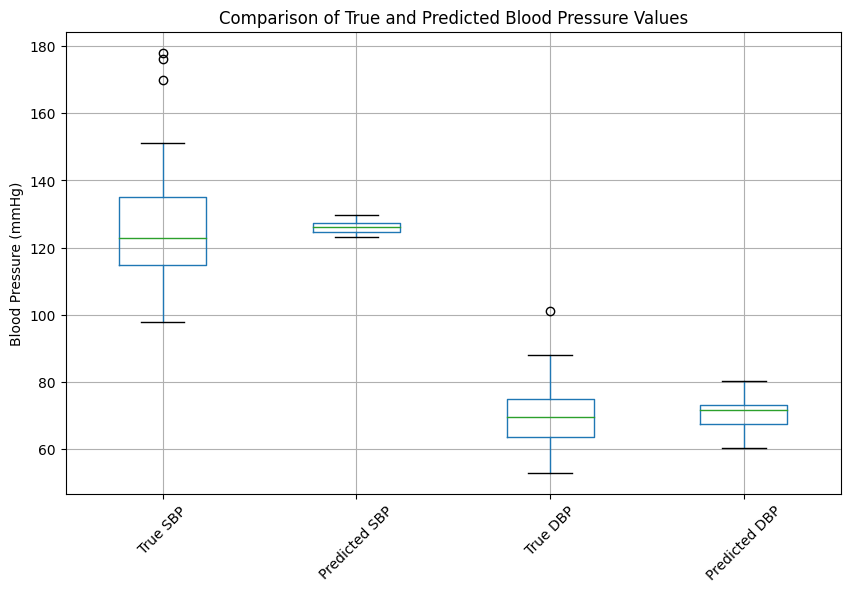

In [34]:
import matplotlib.pyplot as plt

# Combine true and predicted values into a single DataFrame for plotting
comparison_df = pd.DataFrame({
    'True SBP': y_test_sbp,
    'Predicted SBP': sbp_predictions,
    'True DBP': y_test_dbp,
    'Predicted DBP': dbp_predictions
})

# Create a boxplot
plt.figure(figsize=(10, 6))
comparison_df.boxplot()
plt.title('Comparison of True and Predicted Blood Pressure Values')
plt.ylabel('Blood Pressure (mmHg)')
plt.xticks(rotation=45)
plt.show()

# Show the plot
plt.show()

## Saving models

In [ ]:
joblib.dump(best_sbp_model, 'best_sbp_model.pkl')
joblib.dump(best_dbp_model, 'best_dbp_model.pkl')